# Collaborative filtering


With _collaborative filtering_, we will not use any external features, but use the pairwise relationship between users and item directly.  

A great advantage: Making recommendations based on seemingly unrelated topics.  For example, we can keep track of someone's beer and movie ratings, and predict beer tastes based on someone's movie preferences (assuming there's a correlation between the two).

We have two kinds of collaborative filtering:

- `Item-based collaborative filtering`
- `Model-based collaborative filtering`

<hr>

## Item-based collaborative filtering

For _item-based collaborative filtering_, recommendations for each user are based on similar items that the user has already rated highly. 

"because you liked this, we think you'd also like this..". 

#### Example: Who To Follow — Recommending Brands

In this example, we consider a simple dataset: users following brands. We only know of a user follows a brand or not, but not how much he or she likes this brand.  Given the brands the user is following, we would like to recommend similar brands that s/he might be interested in.  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
%matplotlib inline

In [80]:
data = pd.read_csv('user-brands.csv')
print "We have %d pairs of ratings between %s users and %s brands." % \
    (len(data), data.id.nunique(), data.brand.nunique())
data.head()

We have 23804 pairs of ratings between 3759 users and 198 brands.


,id,brand
0,80002,Target
1,80002,Home Depot
2,80010,Levi's
3,80010,Puma
4,80010,Cuisinart


### Step 1: Create a User-by-brand matrix

Note that our data above is in condensed format. We could make it into a sparse matrix, which might be easier to work with.  You could do this with `pd.pivot_table`:

    M = pd.pivot_table(data, index='id', columns='brand', aggfunc='size', fill_value=0)

We use a `groupby` statement, which gives us a multi-index series, and then we make an `unstack` call to transform it into a dataframe again.  

In [30]:
M = data.groupby(['id', 'brand']).size().unstack().fillna(0)
n_users, n_brands = M.shape
brands = M.columns
M.head(3)

brand,6pm.com,Abercrombie & Fitch,Adidas,Aeropostale,Aldo,All Saints,Amazon.com,American Apparel,American Eagle,Ann Taylor,...,Walgreens,Walk-Over,Wet Seal,Windsor,YSL,Yves Saint Laurent,ZOO,Zara,Zipcar,vineyard vines
id,,,,,,,,,,,,,,,,,,,,,
80002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Step 2: Create a brand-by-brand matrix, with the similarity distances between two brands in each cell

- Obviously, you'd have $Distance_{ii} = 0$ for each brand $i$, and $Distance_{ij} = Distance_{ji}$ for each pair of brands.
- You can create a 2-dimenional `np.array` for this, or a nested dictionary `Distance = {i: {j1: distance1, j2: distance2, etc}}`, or anything you like.

Since we will use a neighborhood method, we need a definition of _distance_.  We'll use the _Jaccard distance_ for this. (Also see an earlier notebook on SVD which covered the Jaccard distance.)

#### Jaccard distance

The [_Jaccard index_](https://en.wikipedia.org/wiki/Jaccard_index) is a similarity metric between two sets.  It measures how many elements two sets have in common, as a fraction of the total number of distinct elements in both sets.  

$$\text{Jaccard index} = \frac{ |A \cap B | }{ |A \cup B| }$$

We could make a Jaccard matrix $J$, with pairwise similarities $J_{ij}$ as entries.
- `J[i, j]` = Jaccard similarity between doc _i_ and _j_ (between 0 and 1)
- `J[i, i]` = 1, obviously, and
- `J[i, j]` = `J[i, j]`, i.e., the matrix is symmetric.

We could also define the [_Jaccard distance_](https://en.wikipedia.org/wiki/Jaccard_distance) , which has $D_{ii} = 0$ for identical sets, and bigger values as the sets have less words in common.  We define: $D = 1 - J,$ which has values between 0 and 1.

Common applications of the Jaccard index include text clustering, but we can use it for brand clustering as well, counting the number of followers they have in common.

In [5]:
def jaccard_distance(M):
    I = M.T.dot(M)  # number of users in common 
    n_users_per_brand = np.diag(I)
    N = n_users_per_brand.reshape(n_brands, 1) * np.ones(n_brands)
    U = N + N.T - I  # total unique followers = n_users_i + n_users_j - users in common
    J = I / U.astype(float)  # similarity matrix
    D = 1 - J  # distance
    return D

In [6]:
brand_distance = jaccard_distance(M)
brand_distance.head(3)

brand,6pm.com,Abercrombie & Fitch,Adidas,Aeropostale,Aldo,All Saints,Amazon.com,American Apparel,American Eagle,Ann Taylor,...,Walgreens,Walk-Over,Wet Seal,Windsor,YSL,Yves Saint Laurent,ZOO,Zara,Zipcar,vineyard vines
brand,,,,,,,,,,,,,,,,,,,,,
6pm.com,0.000000,0.996255,0.996154,0.996241,1.0,1.0,1.0,0.996183,0.996441,0.992481,...,1.0,1.0,1.0000,1.0,1.0,1.0,1.0,1.000000,1.0,1.0
Abercrombie & Fitch,0.996255,0.000000,1.000000,0.928571,1.0,1.0,1.0,1.000000,0.888889,1.000000,...,1.0,1.0,0.9375,1.0,1.0,1.0,1.0,0.909091,1.0,1.0
Adidas,0.996154,1.000000,0.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,...,1.0,1.0,1.0000,1.0,1.0,1.0,1.0,1.000000,1.0,1.0


Note that this is a _distance_ matrix, so the lower, the closer, the more similar.  Hence we have zeros on the diagonal.

Let's show the top most similar brands for some known brands.

In [72]:
top = 5
for brand in ['Home Depot', 'Armani', 'UNIQLO']:
    print "%-20s:" % brand, 
    print ", ".join(brand_distance[brand].sort_values(inplace=False).index[:top]) 

Home Depot          : Home Depot, Target, Kohl's, Old Navy, Crate & Barrel
Armani              : Armani, Ecco, Hugo Boss, Giorgio Armani, Horchow
UNIQLO              : UNIQLO, American Apparel, 6pm.com, Shoebuy, Columbia


And let's pick some other random brands.

In [114]:
n_show = 5  # show a few brands
print "Top %d similar brands for some random %d brands" % (top, n_show)
for brand in np.random.choice(brands, n_show, replace=False):
    print "%-20s:" % brand, 
    print ", ".join(brand_distance[brand].sort_values(inplace=False).index[:top])

Top 5 similar brands for some random 5 brands
Calvin Klein        : Calvin Klein, Guess, DKNY, Kenneth Cole, Steve Madden
Lululemon           : Lululemon, Lord & Taylor, Saucony, Boden, UGG Australia
L'occitane          : L'occitane, Discovery Channel Store, Prada, Abercrombie & Fitch, American Eagle
O'Neill             : Rip Curl, Billabong, Roxy, O'Neill, Sephora
Vera Bradley        : Vera Bradley, Shashi, Michael Kors, Coach, Victoria's Secret


### Step 3: Making recommendations for users

   - Per user, find out the brands he/she is already following
   - For each brand followed by this user, compute its distance to all other brands
   - For each unfollowed brand, average its distances to all the already followed brands
   - Identify the brands with the shortest average distance
 
Make sure you exclude the brands the user is already following from the recommendations!

In [110]:
def recommend_brands_for_user(user, M, top=5):
    user_brands = M.loc[user][M.loc[user] > 0].index  
    brand_distance = jaccard_distance(M)        
    recs = brand_distance[user_brands].mean(axis=1).sort_values(ascending=True, inplace=False).index
    recs = [rec for rec in recs if rec not in user_brands]
    return recs[:top]

In [116]:
n_users = 4
# for user in [90217, 86156, 89116, 89112]:
for user in np.random.choice(M.index, n_users, replace=False):
    print "User %s" % user
    print "Already following:", ", ".join(brands[M.loc[user] > 0])
    print "Recommended:", ", ".join(recommend_brands_for_user(user, M))
    print

User 86082
Already following: Cuisinart, Nine West, Shoebuy
Recommended: KitchenAid, Crate & Barrel, DKNY, Steve Madden, Levi's

User 87965
Already following: Crate & Barrel, Home Depot, Nordstrom
Recommended: Target, KitchenAid, Old Navy, Gap, Container Store

User 80229
Already following: Banana Republic, Guess, Home Depot, KitchenAid, Nordstrom, Shoebuy
Recommended: Cuisinart, Crate & Barrel, Gap, Express, Target

User 81277
Already following: Crate & Barrel, Home Depot, Kohl's, Target
Recommended: Old Navy, KitchenAid, Gap, Nordstrom, Container Store



<hr>

## Model-based collaborative filtering

In _model-based collaborative filtering_ we will estimate parameters for both items and users simultaneously.  This apporach is considered to be the state of the art and gets generally the highest prediction accuracy.

The most popular model-based CF techniques use [_Matrix decomposition_](https://en.wikipedia.org/wiki/matrix_decomposition) techniques to find deeper structure in the ratings data.  For example, we could decompose the ratings matrix via SVD to reduce the dimensionality and extract latent variables. 

Once we identify the latent variables in the ratings matrix, we can express both users and items in terms of these latent variables.  As before, values in the item vectors represent the degree to which an item exhibits a given feature, and values in the user vectors represent user preferences for a given feature.  Ratings are constructed by taking dot products of user & item vectors in the latent feature space.

In [13]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [117]:
print "The original matrix has {} rows(users) and {} columns(brands).".format(M.shape[0],M.shape[1])

The original matrix has 3759 rows(users) and 198 columns(brands).


In [34]:
n_components = 30 
svd = TruncatedSVD(n_components)
X_red = svd.fit_transform(M)
explained_variance = svd.explained_variance_ratio_.sum()

In [118]:
print "The reduced matrix has {} rows and {} columns.".format(X_red.shape[0],X_red.shape[1])

The reduced matrix has 3759 rows and 30 columns.


SVD with 30 components explained 83% of variance in preference


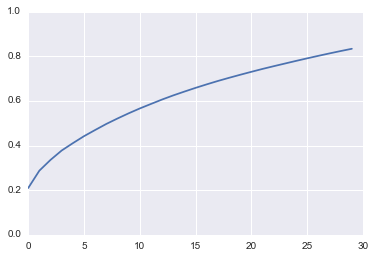

In [94]:
print "SVD with {} components explained {:.0f}% of variance in preference".format(n_components,explained_variance * 100)
plt.plot(svd.explained_variance_ratio_.cumsum())
f = plt.ylim(0,1)

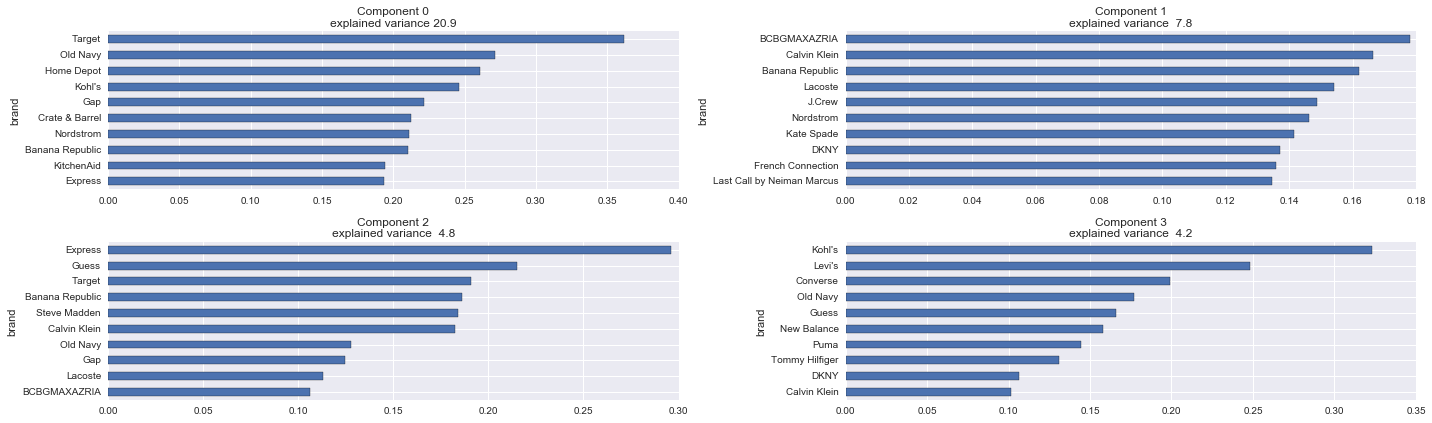

In [101]:
top_rec = 10
n_rows, n_cols = 2, 2
top_components = n_rows * n_cols
f, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
for no, component in enumerate(svd.components_[:top_components]):
    ax = axes[no / n_cols][no % n_cols]
    s = pd.Series(svd.components_[no], index=brands).sort_values(inplace=False)[-top_rec:]
    s.plot(kind='barh', ax=ax, title="Component %d\nexplained variance %4.1f" % 
           (no, 100 * svd.explained_variance_ratio_[no]))
f = plt.tight_layout()

In [69]:
user_id = np.random.choice(M.index.values)
user_index = list(M.index.values).index(user_id)

data[data.id==user_id]

,id,brand
10348,85467,New Balance
10349,85467,Target


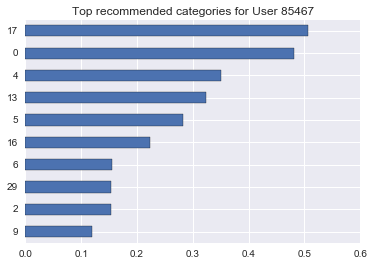

In [63]:
recs = pd.Series(X_red[user_index])
f = recs.sort_values(inplace=False)[-10:].plot(kind='barh', title='Top recommended categories for User %s' % user_id)

In [64]:
brands_from_top_category = pd.Series(svd.components_[recs.argmax()], index=brands)
print "Brands from top recommended category for User %s:" % user_id,
print ', '.join(brands_from_top_category.sort_values(inplace=False)[-top_rec:].index)

Brands from top recommended category for user 85467: Steve Madden, BCBGMAXAZRIA, Lands' End, Columbia, Calvin Klein, Kate Spade, Guess, J.Crew, Container Store, New Balance


Take dot product again to get individual brands recommended for user.  Note that brands are represented in different components, so this is really a different set than the one before.

In [66]:
brands_recs = X_red[user_index].dot(svd.components_)
brands_recs = pd.Series(brands_recs, index=brands)
print "Brands recommended for User %s:" % user_id,
print ', '.join(brands_recs.sort_values(inplace=False)[-top_rec:].index)

Brands recommended for User 85467: Converse, Lands' End, Kate Spade, Mikasa, BCBGMAXAZRIA, Kenneth Cole, Shoebuy, Le Creuset, New Balance, Target
